In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('../utils')
from UCB1 import UCB1PricingAgent
from Thompson import ThompsonSamplingPricingAgent

# Environment Setup

In [2]:
class StochasticPricingEnvironment:
    """
    Stochastic environment with a distribution over customer valuations for a single product.
    The demand probability depends on the price and the distribution of customer valuations.
    """
    def __init__(self, valuation_distribution, demand_noise_std=0.1):
        """
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
            demand_noise_std: Standard deviation of noise in demand probability
        """
        self.valuation_dist = valuation_distribution
        self.noise_std = demand_noise_std


    def demand_probability(self, price):
        """
        Calculate the probability that a customer buys at given price.
        This is P(valuation >= price) with some noise.
        """
        # Base probability: customers buy if their valuation >= price
        base_prob = 1 - self.valuation_dist.cdf(price)
        
        # Add some noise to make it stochastic
        noise = np.random.normal(0, self.noise_std)
        
        prob = base_prob + noise
        # Ensure probability is in [0, 1]
        return np.clip(prob, 0, 1)
    

    def simulate_round(self, price):
        
        """
        Simulate one pricing round.
        Returns: (sale_made, revenue)
        """
        # Draw a random customer valuation from the distribution
        valuation = self.valuation_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        return sale_made, revenue
       

# Testing the UCB1 Pricing Agent with a Stochastic Environment

Create the stochastic environment and the agent

Customer valuation distribution: Normal(μ=0.5, σ=0.1)
Number of price options: 11
UCB confidence bound: 1


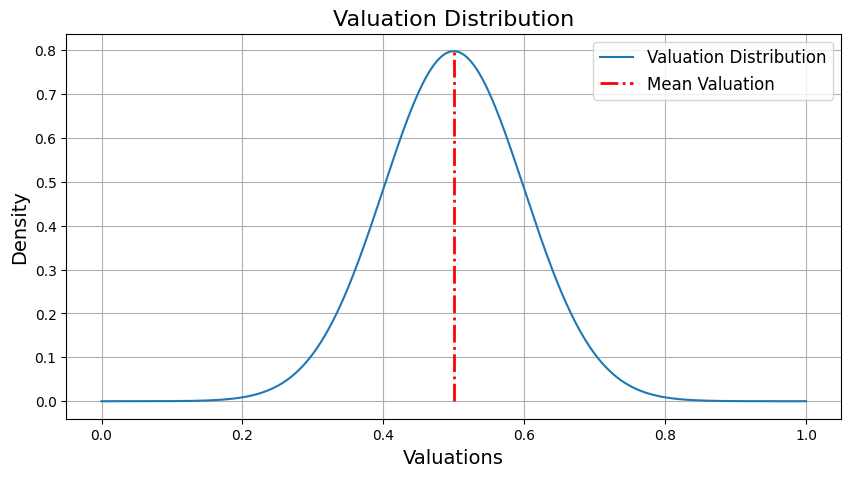

In [3]:
# Environment Configuration
env_config = {
    'valuation_mean': 0.5,  # Average customer valuation
    'valuation_std': 0.1,   # Standard deviation of customer valuations
    'demand_noise_std': 0  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

x = np.linspace(0, 1, 1000)
y = (1 / (env_config['valuation_mean'] * np.sqrt(2 * np.pi))) * np.exp(-(x - env_config['valuation_mean'])**2 / (2 * env_config['valuation_std']**2))

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Valuation Distribution', color='#1f77b4')  # Colore blu chiaro
plt.vlines(0.5, color='red', lw=2, ls='-.', ymin=0, ymax=max(y), label='Mean Valuation')  # Linea verticale rossa
plt.title('Valuation Distribution', fontsize=16)
plt.xlabel('Valuations', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)


# Agent configuration
ucb_params = {
    'confidence_bound': 1,  # UCB exploration parameter
    'prices': [0,0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1]
}

thompson_params = {
    'prices': [0,0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1],
    'alpha_prior' : 1.0,  # Prior successes
    'beta_prior' : 1.0   # Prior failures
}

print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(ucb_params['prices'])}")
print(f"UCB confidence bound: {ucb_params['confidence_bound']}")

# set random seed for reproducibility
np.random.seed(42) 

Theoretical analysis of the optimal price, performed before running the agent

In [4]:
# Theoretical Analysis: Calculate optimal price and expected revenues
print("=== Theoretical Analysis ===")

# For each price, calculate the theoretical expected revenue
theoretical_revenues = []
for price in ucb_params['prices']:
    # Expected demand probability (without noise)
    demand_prob = 1 - valuation_dist.cdf(price)
    expected_revenue = price * demand_prob
    theoretical_revenues.append(expected_revenue)
    print(f"Price {price:}: P(buy) = {demand_prob:.3f}, E[Revenue] = {expected_revenue:.2f}")

# Find the optimal price theoretically
optimal_idx = np.argmax(theoretical_revenues)
optimal_price = ucb_params['prices'][optimal_idx]
optimal_revenue = theoretical_revenues[optimal_idx]

print(f"\nOptimal price (theoretical): {optimal_price}")
print(f"Optimal expected revenue: {optimal_revenue:.2f}")

# Store optimal information for later comparison
optimal_info = {
    'price': optimal_price,
    'price_idx': optimal_idx,
    'expected_revenue': optimal_revenue,
    'theoretical_revenues': theoretical_revenues
} 

=== Theoretical Analysis ===
Price 0: P(buy) = 1.000, E[Revenue] = 0.00
Price 0.1: P(buy) = 1.000, E[Revenue] = 0.10
Price 0.2: P(buy) = 0.999, E[Revenue] = 0.20
Price 0.3: P(buy) = 0.977, E[Revenue] = 0.29
Price 0.4: P(buy) = 0.841, E[Revenue] = 0.34
Price 0.5: P(buy) = 0.500, E[Revenue] = 0.25
Price 0.6: P(buy) = 0.159, E[Revenue] = 0.10
Price 0.7: P(buy) = 0.023, E[Revenue] = 0.02
Price 0.8: P(buy) = 0.001, E[Revenue] = 0.00
Price 0.9: P(buy) = 0.000, E[Revenue] = 0.00
Price 1: P(buy) = 0.000, E[Revenue] = 0.00

Optimal price (theoretical): 0.4
Optimal expected revenue: 0.34


# Run UCB Simulation

In [5]:
# Run Comparative Simulation: UCB1 vs Thompson Sampling
print("\n=== Running Comparative Simulation: UCB1 vs Thompson Sampling ===")

T = 10000  # Number of rounds
n_simulations = 1  # Number of simulations

# Results storage for both algorithms
results = {
    'UCB1': {
        'selected_prices': [],
        'revenues': [],
        'sales': [],
        'cumulative_revenue': [],
        'cumulative_regret': [],
        'total_revenue': 0
    },
    'Thompson': {
        'selected_prices': [],
        'revenues': [],
        'sales': [],
        'cumulative_revenue': [],
        'cumulative_regret': [],
        'total_revenue': 0
    }
}

for sim in range(n_simulations):
    print(f"\nRunning simulation {sim + 1} for {T} rounds...")
    
    # Create the stochastic environment (same for both agents)
    env = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist,
        demand_noise_std=env_config['demand_noise_std']
    )
    
    # Create both agents
    ucb_agent = UCB1PricingAgent(**ucb_params)
    thompson_agent = ThompsonSamplingPricingAgent(**thompson_params)
    
    # Set same random seed for fair comparison
    np.random.seed(42)
    
    for t in range(T):
        # UCB1 Algorithm
        ucb_price = ucb_agent.select_price()
        ucb_sale_made, ucb_revenue = env.simulate_round(ucb_price)
        ucb_agent.update(ucb_sale_made, ucb_revenue)
        
        # Record UCB1 results
        results['UCB1']['selected_prices'].append(ucb_price)
        results['UCB1']['revenues'].append(ucb_revenue)
        results['UCB1']['sales'].append(ucb_sale_made)
        results['UCB1']['total_revenue'] += ucb_revenue
        results['UCB1']['cumulative_revenue'].append(results['UCB1']['total_revenue'])
        
        # Calculate UCB1 regret
        ucb_regret = optimal_revenue - ucb_revenue
        if t == 0:
            results['UCB1']['cumulative_regret'].append(ucb_regret)
        else:
            results['UCB1']['cumulative_regret'].append(results['UCB1']['cumulative_regret'][-1] + ucb_regret)
        
        # Reset environment state for Thompson Sampling (same customer)
        np.random.seed(42 + t)  # Ensure same random customer for fair comparison
        
        # Thompson Sampling Algorithm
        thompson_price = thompson_agent.select_price()
        thompson_sale_made, thompson_revenue = env.simulate_round(thompson_price)
        thompson_agent.update(thompson_sale_made, thompson_revenue)
        
        # Record Thompson results
        results['Thompson']['selected_prices'].append(thompson_price)
        results['Thompson']['revenues'].append(thompson_revenue)
        results['Thompson']['sales'].append(thompson_sale_made)
        results['Thompson']['total_revenue'] += thompson_revenue
        results['Thompson']['cumulative_revenue'].append(results['Thompson']['total_revenue'])
        
        # Calculate Thompson regret
        thompson_regret = optimal_revenue - thompson_revenue
        if t == 0:
            results['Thompson']['cumulative_regret'].append(thompson_regret)
        else:
            results['Thompson']['cumulative_regret'].append(results['Thompson']['cumulative_regret'][-1] + thompson_regret)

print(f"\nSimulation completed!")

# Print comparative results
for algorithm in ['UCB1', 'Thompson']:
    print(f"\n{algorithm} Results:")
    print(f"  Total revenue: {results[algorithm]['total_revenue']:.2f}")
    print(f"  Average revenue per round: {results[algorithm]['total_revenue']/T:.4f}")
    print(f"  Final regret: {results[algorithm]['cumulative_regret'][-1]:.2f}")
    
    # Get best price for each algorithm
    if algorithm == 'UCB1':
        best_price, best_avg_revenue = ucb_agent.get_best_price()
    else:
        best_price, best_avg_revenue = thompson_agent.get_best_price()
    
    print(f"  Best price found: {best_price} (avg revenue: {best_avg_revenue:.4f})")

print(f"\nTheoretical optimal: {optimal_price} (expected revenue: {optimal_revenue:.4f})")

# Calculate price selection frequencies
for algorithm in ['UCB1', 'Thompson']:
    price_counts = np.bincount([ucb_params['prices'].index(p) for p in results[algorithm]['selected_prices']], 
                              minlength=len(ucb_params['prices']))
    results[algorithm]['price_counts'] = price_counts


=== Running Comparative Simulation: UCB1 vs Thompson Sampling ===

Running simulation 1 for 10000 rounds...

Simulation completed!

UCB1 Results:
  Total revenue: 2851.30
  Average revenue per round: 0.2851
  Final regret: 514.08
  Best price found: 0.4 (avg revenue: 0.3382)

Thompson Results:
  Total revenue: 3314.10
  Average revenue per round: 0.3314
  Final regret: 51.28
  Best price found: 0.4 (avg revenue: 0.3346)

Theoretical optimal: 0.4 (expected revenue: 0.3365)


In [6]:
# Comparative Performance Analysis
print("\n=== Comparative Performance Analysis ===")

# Calculate theoretical optimal for comparison
theoretical_total = optimal_revenue * T

for algorithm in ['UCB1', 'Thompson']:
    print(f"\n{algorithm} Performance:")
    total_revenue = results[algorithm]['total_revenue']
    final_regret = results[algorithm]['cumulative_regret'][-1]
    
    print(f"  Actual total revenue: {total_revenue:.2f}")
    print(f"  Total regret: {final_regret:.2f}")
    print(f"  Regret percentage: {100 * final_regret / theoretical_total:.2f}%")
    print(f"  Revenue efficiency: {100 * total_revenue / theoretical_total:.2f}%")
    
    # Price selection frequency
    price_counts = results[algorithm]['price_counts']
    print(f"  Price selection frequency:")
    for i, (price, count) in enumerate(zip(ucb_params['prices'], price_counts)):
        percentage = 100 * count / T
        marker = " ← OPTIMAL" if i == optimal_idx else ""
        print(f"    Price {price}: {count:4d} times ({percentage:5.1f}%){marker}")

print(f"\nComparative Summary:")
print(f"Theoretical optimal total revenue: {theoretical_total:.2f}")
ucb_efficiency = 100 * results['UCB1']['total_revenue'] / theoretical_total
thompson_efficiency = 100 * results['Thompson']['total_revenue'] / theoretical_total
print(f"UCB1 efficiency: {ucb_efficiency:.2f}%")
print(f"Thompson efficiency: {thompson_efficiency:.2f}%")

if thompson_efficiency > ucb_efficiency:
    print(f"Thompson Sampling outperformed UCB1 by {thompson_efficiency - ucb_efficiency:.2f} percentage points")
else:
    print(f"UCB1 outperformed Thompson Sampling by {ucb_efficiency - thompson_efficiency:.2f} percentage points")


=== Comparative Performance Analysis ===

UCB1 Performance:
  Actual total revenue: 2851.30
  Total regret: 514.08
  Regret percentage: 15.28%
  Revenue efficiency: 84.72%
  Price selection frequency:
    Price 0:  119 times (  1.2%)
    Price 0.1:  213 times (  2.1%)
    Price 0.2:  488 times (  4.9%)
    Price 0.3: 1818 times ( 18.2%)
    Price 0.4: 5829 times ( 58.3%) ← OPTIMAL
    Price 0.5:  819 times (  8.2%)
    Price 0.6:  224 times (  2.2%)
    Price 0.7:  133 times (  1.3%)
    Price 0.8:  119 times (  1.2%)
    Price 0.9:  119 times (  1.2%)
    Price 1:  119 times (  1.2%)

Thompson Performance:
  Actual total revenue: 3314.10
  Total regret: 51.28
  Regret percentage: 1.52%
  Revenue efficiency: 98.48%
  Price selection frequency:
    Price 0:    0 times (  0.0%)
    Price 0.1:    0 times (  0.0%)
    Price 0.2:    0 times (  0.0%)
    Price 0.3:    1 times (  0.0%)
    Price 0.4: 9845 times ( 98.5%) ← OPTIMAL
    Price 0.5:   74 times (  0.7%)
    Price 0.6:   10 times (

# Plot the results


=== Generating Comparative Visualizations ===


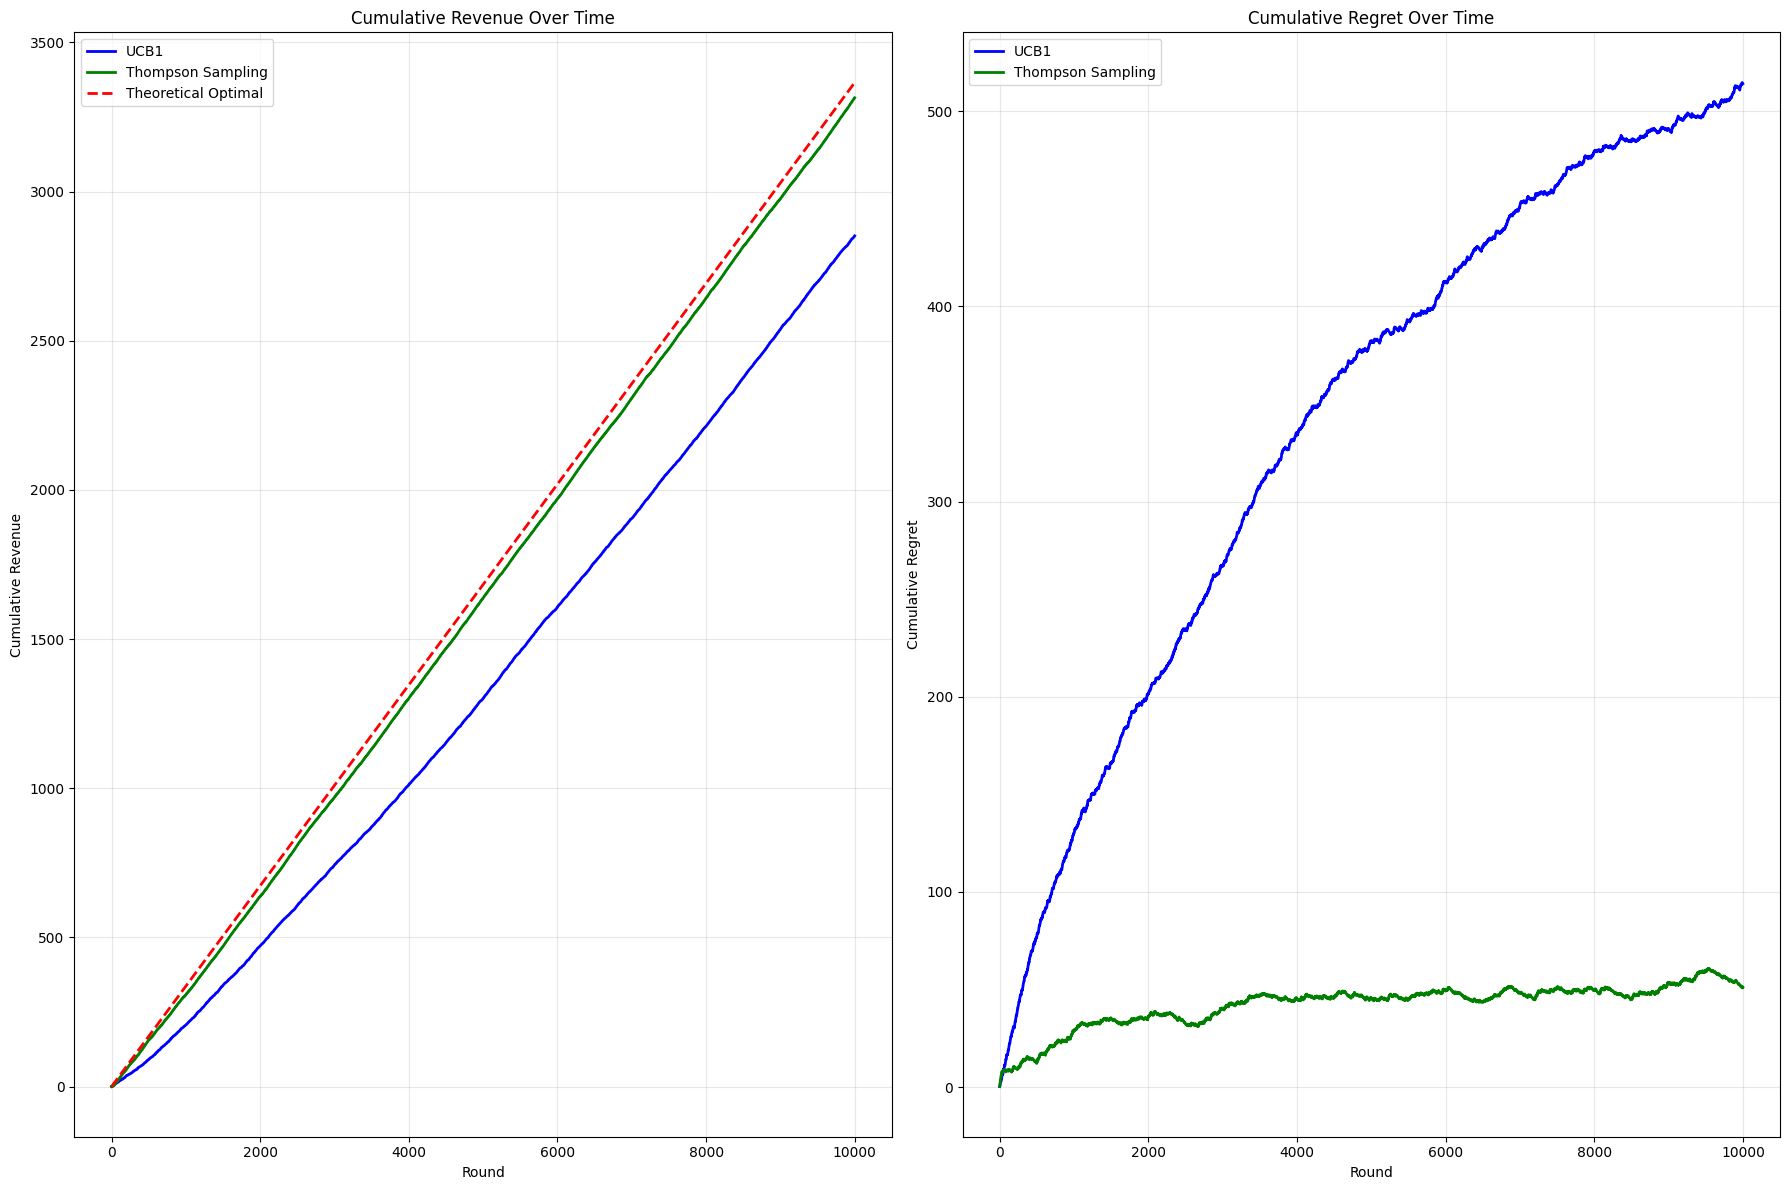


Numerical Comparison Summary:
Metric                    UCB1         Thompson     Difference  
-----------------------------------------------------------------
Final Revenue             2851.30      3314.10      462.80      
Final Regret              514.08       51.28        -462.80     
Avg Revenue/Round         0.2851       0.3314       0.0463      
Optimal Price Selections  5829         9845         4016        
Optimal Selection %       58.29        98.45        40.16       


In [9]:
# Comparative Visualization
print("\n=== Generating Comparative Visualizations ===")

# Create comprehensive comparison plots
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# 1. Cumulative Revenue Comparison
axes[0].plot(results['UCB1']['cumulative_revenue'], 'b-', label='UCB1', linewidth=2)
axes[0].plot(results['Thompson']['cumulative_revenue'], 'g-', label='Thompson Sampling', linewidth=2)
axes[0].plot([0, T], [0, theoretical_total], 'r--', label='Theoretical Optimal', linewidth=2)
axes[0].set_xlabel('Round')
axes[0].set_ylabel('Cumulative Revenue')
axes[0].set_title('Cumulative Revenue Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Cumulative Regret Comparison
axes[1].plot(results['UCB1']['cumulative_regret'], 'b-', label='UCB1', linewidth=2)
axes[1].plot(results['Thompson']['cumulative_regret'], 'g-', label='Thompson Sampling', linewidth=2)
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Cumulative Regret')
axes[1].set_title('Cumulative Regret Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical comparison
print(f"\nNumerical Comparison Summary:")
print(f"{'Metric':<25} {'UCB1':<12} {'Thompson':<12} {'Difference':<12}")
print("-" * 65)
print(f"{'Final Revenue':<25} {results['UCB1']['total_revenue']:<12.2f} {results['Thompson']['total_revenue']:<12.2f} {results['Thompson']['total_revenue'] - results['UCB1']['total_revenue']:<12.2f}")
print(f"{'Final Regret':<25} {results['UCB1']['cumulative_regret'][-1]:<12.2f} {results['Thompson']['cumulative_regret'][-1]:<12.2f} {results['Thompson']['cumulative_regret'][-1] - results['UCB1']['cumulative_regret'][-1]:<12.2f}")
print(f"{'Avg Revenue/Round':<25} {results['UCB1']['total_revenue']/T:<12.4f} {results['Thompson']['total_revenue']/T:<12.4f} {(results['Thompson']['total_revenue'] - results['UCB1']['total_revenue'])/T:<12.4f}")

# Count how often each algorithm selected the optimal price
ucb_optimal_selections = results['UCB1']['price_counts'][optimal_idx]
thompson_optimal_selections = results['Thompson']['price_counts'][optimal_idx]
print(f"{'Optimal Price Selections':<25} {ucb_optimal_selections:<12} {thompson_optimal_selections:<12} {thompson_optimal_selections - ucb_optimal_selections:<12}")
print(f"{'Optimal Selection %':<25} {100*ucb_optimal_selections/T:<12.2f} {100*thompson_optimal_selections/T:<12.2f} {100*(thompson_optimal_selections - ucb_optimal_selections)/T:<12.2f}")
